In [2]:
%load_ext autoreload

In [3]:
%autoreload
import geopandas as gpd
import shapely
import pandas as pd
import numpy as np
import fiona
import rasterio
import rasterio.mask
import rasterio.merge
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.fill import fillnodata
from rasterio.plot import show
import nexus_tool.weap_tools as wp
import os
import matplotlib.pyplot as plt
from shutil import copyfile
from datetime import date

## Reading files

In [3]:
provinces = gpd.read_file('Data - Souss-Massa/GIS/Admin/Provinces.gpkg', encoding='utf-8')
groundwater = gpd.read_file('Data - Souss-Massa/Schematic/Groundwater.kml', encoding='utf-8')
wwtp = gpd.read_file('Data - Souss-Massa/Schematic/Wastewater Treatment Plants.kml', encoding='utf-8')
other_supply = gpd.read_file('Data - Souss-Massa/Schematic/Other Supplies.kml', encoding='utf-8')
river_withdrawals = gpd.read_file('Data - Souss-Massa/Schematic/River Withdrawals.kml', encoding='utf-8')
demand_sites = gpd.read_file('Data - Souss-Massa/Schematic/Demand Sites.kml', encoding='utf-8')
catchments = gpd.read_file('Data - Souss-Massa/Schematic/Catchments.kml', encoding='utf-8')
diversion = gpd.read_file('Data - Souss-Massa/Schematic/Diversions.kml', encoding='utf-8')
reservoirs = gpd.read_file('Data - Souss-Massa/Schematic/Reservoirs.kml', encoding='utf-8')
links = gpd.read_file('Data - Souss-Massa/Schematic/Transmission Links.kml', encoding='utf-8')

## Converting geometries and dropping unecesary columns

In [4]:
for gdf in [groundwater, wwtp, other_supply, river_withdrawals,
            demand_sites, catchments, diversion, reservoirs, links]:
    gdf['geometry'] = wp.polyz_to_poly(gdf)
    gdf.drop(columns='Description', inplace=True)

In [5]:
for gdf in [groundwater, wwtp, other_supply, river_withdrawals,
            reservoirs, demand_sites, catchments]:
    gdf.rename(columns={'Name': 'point'}, inplace=True)

links.rename(columns={'Name': 'links'}, inplace=True)
diversion.rename(columns={'Name': 'diversion'}, inplace=True)

## Defining types

In [6]:
groundwater['type'] = 'Groundwater supply'
wwtp['type'] = 'WWTP'
other_supply['type'] = 'Other supply'
river_withdrawals['type'] = 'Surfacewater withdrawal'
reservoirs['type'] = 'Reservoir supply'
catchments['type'] = 'Catchment'
demand_sites['type'] = 'Demand site'
diversion['type'] = 'Transmission Pipeline'
links['type'] = 'Transmission links'

In [7]:
# other_supply['point'] = 'Prelevement 3'
supply_points = groundwater.append([other_supply, reservoirs, river_withdrawals], ignore_index=True, sort=False)
demand_points = demand_sites.append(catchments, ignore_index=True, sort=False)
links['links'] = links.links.str.replace('Groundwater','GW')
links['links'] = links.links.str.replace('Grounwater','GW')
links['links'] = links.links.str.replace('GW of ','')
links['links'] = links.links.str.replace('GW ','')
links['links'] = links.links.str.strip()
links['links'] = links.links.str.replace(' El Guerdane',' I_El Guerdane')

In [8]:
demand_links = gpd.sjoin(demand_points, links, how='inner', op='intersects')
supply_links = gpd.sjoin(supply_points, links, how='inner', op='intersects')

In [9]:
demand_links.rename(columns={'type_left': 'type'}, inplace=True)
demand_links.drop(columns=['type_right', 'index_right'], inplace=True)
supply_links.rename(columns={'type_left': 'type'}, inplace=True)
supply_links.drop(columns=['type_right', 'index_right'], inplace=True)

In [10]:
dff = gpd.sjoin(demand_links, provinces[['Province','geometry']], how='inner', op='within')
dff.drop(columns=['index_right'], inplace=True)
df_temp = demand_links.loc[~demand_links.point.isin(dff.point.unique())].copy()
df_temp['Province'] = 'Tiznit'
demand_links = dff.append(df_temp, sort=False)

In [11]:
dff = gpd.sjoin(supply_links, provinces[['Province','geometry']], how='inner', op='within')
dff.drop(columns=['index_right'], inplace=True)
df_temp = supply_links.loc[~supply_links.point.isin(dff.point.unique())].copy()
supply_links = dff.append(df_temp, sort=False)
df_temp['Province'] = 'Chtouka-Aït Baha'
supply_links = dff.append(df_temp, sort=False)

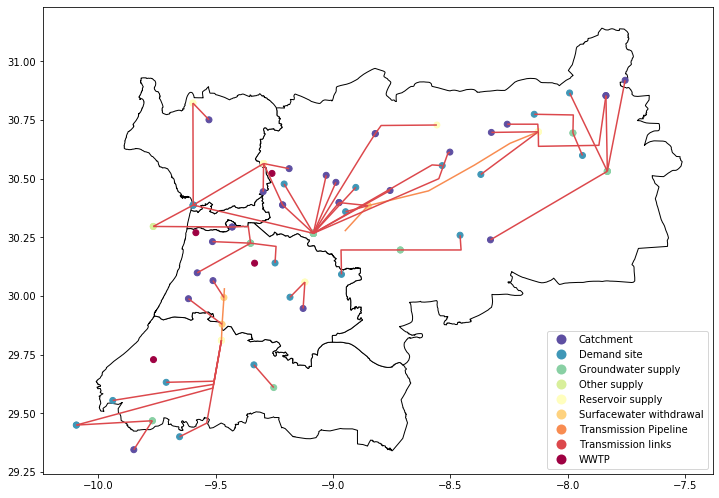

In [12]:
base = provinces.plot(color='white', edgecolor='black', figsize=(12, 12))
data = demand_links.append([supply_links, wwtp, diversion, links], ignore_index=True, sort=False)
data.plot(ax=base, column='type', cmap='Spectral_r', legend=True)
plt.show()

In [13]:
out_image, out_meta = wp.mask_raster('Data - Souss-Massa/GIS/wtd/Africa_model_wtd_v2.nc', 
                                  'Data - Souss-Massa/GIS/Admin/Provinces.gpkg', 'EPSG:4326')
       
with rasterio.open("Data - Souss-Massa/GIS/wtd//Souss-Massa WTD.tif", "w", **out_meta) as dest:
    dest.write(out_image)

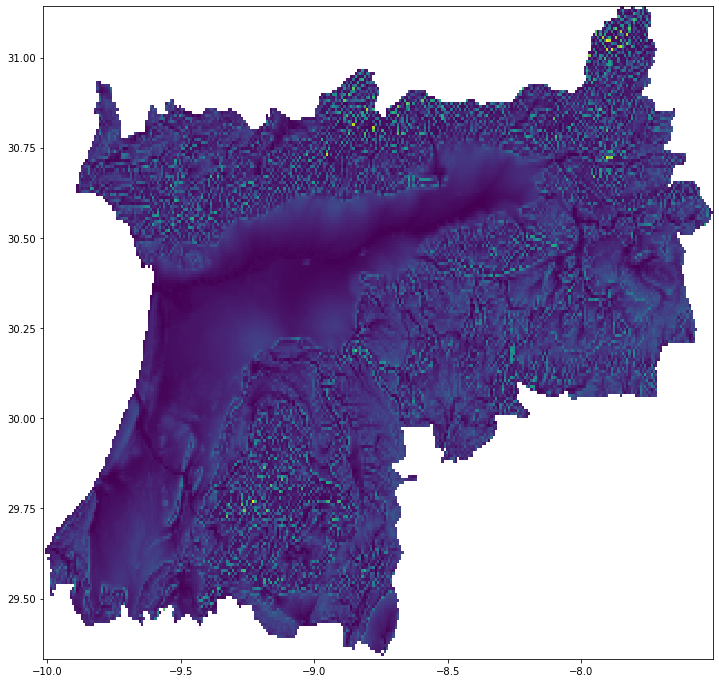

In [14]:
with rasterio.open("Data - Souss-Massa/GIS/wtd//Souss-Massa WTD.tif") as src:
    fig, ax = plt.subplots(figsize=(12, 12))
    show(src, ax=ax, aspect='auto')

In [15]:
groundwater['wtd_m'] = wp.sample_raster("Data - Souss-Massa/GIS/wtd/Africa_model_wtd_v2.nc", 
                                         groundwater)

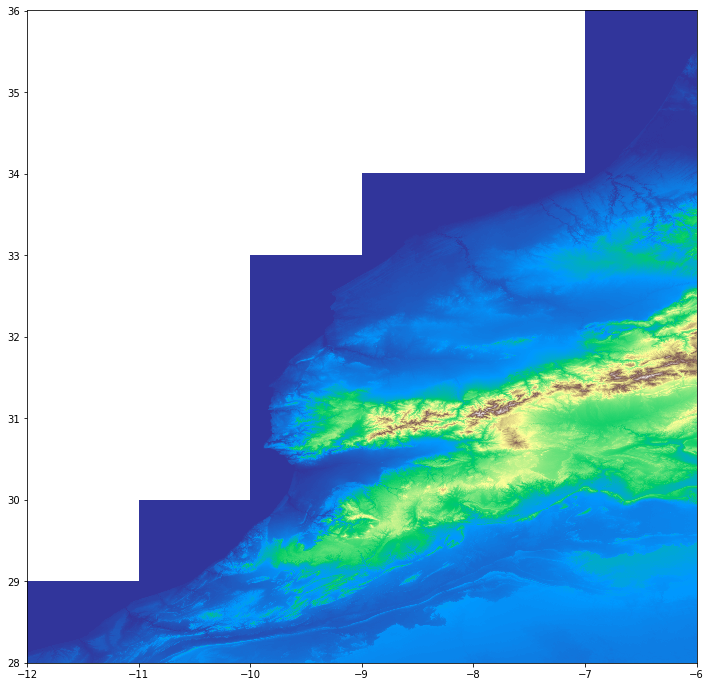

In [16]:
wp.merge_rasters('Data - Souss-Massa/GIS/DEM/*', 'EPSG:4326', 
                 "Data - Souss-Massa/GIS/DEM//Souss-Massa DEM.tif")

with rasterio.open("Data - Souss-Massa/GIS/DEM//Souss-Massa DEM.tif") as src:
    fig, ax = plt.subplots(figsize=(12, 12))
    show(src, ax=ax, aspect='auto', cmap='terrain')

In [17]:
supply_links['elevation_m'] = wp.sample_raster("Data - Souss-Massa/GIS/DEM//Souss-Massa DEM.tif", 
                                               supply_links)
demand_links['elevation_m'] = wp.sample_raster("Data - Souss-Massa/GIS/DEM//Souss-Massa DEM.tif", 
                                               demand_links)
wwtp['elevation_m'] = wp.sample_raster("Data - Souss-Massa/GIS/DEM//Souss-Massa DEM.tif", 
                                       wwtp)

In [18]:
diversions = gpd.sjoin(diversion, reservoirs, how='inner', op='intersects')
diversions.drop(columns=['index_right'], inplace=True)
diversions.rename(columns={'type_right': 'type_supply'}, inplace=True)
diversions = gpd.sjoin(diversions, river_withdrawals, how='inner', op='intersects')
diversions.drop(columns=['index_right'], inplace=True)
diversions.rename(columns={'point_left': 'Supply point', 'point_right': 'Demand point',
                           'type_left': 'type', 'type': 'type_demand'}, inplace=True)

In [19]:
dff1 = river_withdrawals.loc[river_withdrawals.point.isin(diversions['Demand point'])].copy()
dff1['diversion'] = dff1.point.map(diversions.set_index('Demand point').diversion)
dff1['elevation_m'] = wp.sample_raster("Data - Souss-Massa/GIS/DEM//Souss-Massa DEM.tif", 
                                       dff1)

In [20]:
dff2 = reservoirs.loc[reservoirs.point.isin(diversions['Supply point'])].copy()
dff2['diversion'] = dff2.point.map(diversions.groupby('Supply point').agg({'diversion': 'first'})['diversion'])
dff2['elevation_m'] = wp.sample_raster("Data - Souss-Massa/GIS/DEM//Souss-Massa DEM.tif", 
                                       dff2)
MerchidSudMoroc = 26192
dff2.to_crs(f'epsg:{MerchidSudMoroc}', inplace=True)

In [21]:
dff1.to_crs(f'epsg:{MerchidSudMoroc}', inplace=True)
dff1.set_index('diversion', inplace=True)
dff1['distance'] = dff1.distance(dff2.set_index('diversion')).copy()

In [22]:
diversions['distance'] = diversions['Demand point'].map(dff1.set_index('point')['distance'])
diversions['elevation_diff'] = diversions['Demand point'].map(dff1.set_index('point')['elevation_m']) - \
                               diversions['Supply point'].map(dff2.set_index('point')['elevation_m'])

In [23]:
all_points = supply_links.append(demand_links, sort=False, ignore_index=True)
all_points.drop_duplicates(subset="point", inplace=True)

In [24]:
files_dict = {'Reference': {'Climate Change': ['SoussMassa Results - Reference.xlsx']}}

raw_data = os.path.join('Data - Souss-Massa', 'WEAP Results')
results_path = os.path.join('Data - Souss-Massa', 'Processed Results')
wp.create_folder(results_path)
for scenario, files in files_dict.items():
    scenario_path = os.path.join(results_path, scenario)
    wp.create_folder(scenario_path)
    for folder, file in files.items():
        folder_path = os.path.join(scenario_path, folder)
        wp.create_folder(folder_path)
        for i, f in enumerate(file):
            dst = os.path.join(folder_path, f'level_{i+1}')
            wp.create_folder(dst)
            copyfile(os.path.join(raw_data, f), os.path.join(dst, 'results.xlsx'))

In [25]:
def integrate_data(sheet_name, category, dff_dict, var_name='links', target='point'):
    df = data.parse(sheet_name, skiprows=3)
    df.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
    df.columns = df.columns.str.replace('"', '').str.strip()

    df.columns = df.columns.str.replace('Groundwater','GW')
    df.columns = df.columns.str.replace('Grounwater','GW')
    df.columns = df.columns.str.replace('GW of ','')
    df.columns = df.columns.str.replace('GW ','')

    for link in demand_links.links:
        if np.array(df.columns[df.columns.str.contains(link)]).size > 0:
            df.rename(columns={df.columns[df.columns.str.contains(link)][0]: link}, inplace=True)

    df = df.loc[df.Date!='Sum']
    df.Date = pd.to_datetime(df.Date)
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    
    drop_columns = []
    if 'Sum' in df.columns:
        drop_columns.append('Sum')
    df.drop(columns=drop_columns, inplace=True)

    df = df.melt(id_vars=['Date', 'Year', 'Month'])
    
    for name, dff in dff_dict.items():
        df_temp = dff.set_index(var_name)
        if var_name!=target:
            df[name] = df.variable.map(df_temp[target])
    
    df['type'] = category
    df.rename(columns={'variable': var_name}, inplace=True)
    print(df.loc[~df[var_name].isin(df.dropna()[var_name].unique()),var_name].unique())
    return df

In [26]:
scenarios = ['Reference']
processed_data = os.path.join('Data - Souss-Massa', 'Merged data')
wp.create_folder(processed_data)
for scenario in scenarios:
    scenario_folder = os.path.join(results_path, scenario)
    wp.create_folder(os.path.join(processed_data, scenario))
    for sub_scenario in os.listdir(scenario_folder):
        sub_scenario_folder = os.path.join(scenario_folder, sub_scenario)
        wp.create_folder(os.path.join(processed_data, scenario, sub_scenario))
        for level in os.listdir(sub_scenario_folder):
            output_folder = os.path.join(processed_data, scenario, sub_scenario, level)
            wp.create_folder(output_folder)
            file = os.path.join(sub_scenario_folder, level, 'results.xlsx')
            data = pd.ExcelFile(file)
            
            sheet_names = {'Desalination': 'Desalination plant', 
                           'GP Irrigation': 'GW Agriculture', 
                           'GP Domestic': 'GW Domestic',
                           'MAR': 'Aquifer recharge',
                           'SW Irrigation': 'SW Agriculture',
                           'SW Domestic': 'SW Domestic'}
            
            df = pd.DataFrame()
            for sheet_name, category in sheet_names.items():
                df = df.append(integrate_data(sheet_name, category, {'Demand point': demand_links, 
                                                                     'Supply point': supply_links}))
            
            df['wtd'] = df['Supply point'].map(groundwater.set_index('point')['wtd_m'])
            
            wtd_change = integrate_data('GW Change in Elev', 'GW wtd', {'GW': groundwater}, 'point', 'point')
            df.set_index(['Date', 'Supply point'], inplace=True)
            df['wtd'] -= df.index.map(wtd_change.set_index(['Date', 'point']).value)
            df.reset_index(inplace=True)
            
            df['elevation_diff'] = df.links.map(demand_links.set_index('links').elevation_m) - \
                                   df.links.map(supply_links.set_index('links').elevation_m)
            
            dff = df.loc[df['Supply point'].isin(diversions['Demand point'].unique())].groupby(['Date','Supply point','Year','Month']).agg({'value': 'sum'}).reset_index()
            dff.rename(columns={'Supply point': 'Demand point'}, inplace=True)
            dff['Supply point'] = dff['Demand point'].map(diversions.set_index('Demand point')['Supply point'])
            dff['elevation_diff'] = dff['Demand point'].map(diversions.set_index('Demand point')['elevation_diff'])
            dff['Province'] = dff['Supply point'].map(supply_links.drop_duplicates('point').set_index('point')['Province'])
            dff['type'] = 'Transmission Pipeline'
            
            df = df.append(dff, sort=False, ignore_index=True)
            
            df.loc[df.Province.isna(),'Province'] = df['Demand point'].map(demand_links.drop_duplicates('point').set_index('point')['Province'])
            
            supply = gpd.GeoDataFrame(geometry=df['Supply point'].map(all_points.set_index('point').geometry), crs='epsg:4326')
            supply.dropna(inplace=True)
            supply.to_crs(f'epsg:{MerchidSudMoroc}', inplace=True)
            demand = gpd.GeoDataFrame(geometry=df['Demand point'].map(all_points.set_index('point').geometry), crs='epsg:4326')
            demand.dropna(inplace=True)
            demand.to_crs(f'epsg:{MerchidSudMoroc}', inplace=True)
            df['distance'] = supply.distance(demand)
            
            df.loc[df['type'].str.contains('GW'), 'distance'] = df.loc[df['type'].str.contains('GW'), 'wtd']
            df.loc[df['type'].str.contains('GW'), 'elevation_diff'] = df.loc[df['type'].str.contains('GW'), 'wtd']
            
            #temporal fix due to inacurate pleasment of demand points
            df.loc[df['type'].str.contains('SW'), 'distance'] = np.nan
            df.loc[df['type'].str.contains('SW'), 'elevation_diff'] = np.nan
            
            df_wwtp = integrate_data('WWTP Inflow', 'wwtp', {'WWTP': wwtp}, 'point', 'point')
            
            df.to_csv(os.path.join(output_folder, 'demand_data.csv'), index=False)
            df_wwtp.to_csv(os.path.join(output_folder, 'wwtp_inflow.csv'), index=False)
            
            
            

['Transmission Link from Desalination to I_Modern Privé Massa']
[]
[]
[]
[]
[]
[]
[]


The previous printed lines will show transmision links if there was any missmatch between the names in the schematic and the names in the data.

The following block will print the transmission links that are not found in the results. In the current data these are 4, I already rised this with Biran and he said he will fix it for the scenario runs.

In [27]:
demand_links.loc[~demand_links['links'].isin(df['links'].unique()), 'links'].unique()

array([], dtype=object)

In [28]:
df.head()

,Date,Supply point,Year,Month,links,value,Demand point,type,wtd,elevation_diff,Province,distance
0,2019-09-01,Desalination,2019,9,Transmission Link from Desalination to Agadir,0.0,Agadir,Desalination plant,NaN,10.0,Agadir-Ida ou Tanane,19230.740029
1,2019-10-01,Desalination,2019,10,Transmission Link from Desalination to Agadir,0.0,Agadir,Desalination plant,NaN,10.0,Agadir-Ida ou Tanane,19230.740029
2,2019-11-01,Desalination,2019,11,Transmission Link from Desalination to Agadir,0.0,Agadir,Desalination plant,NaN,10.0,Agadir-Ida ou Tanane,19230.740029
3,2019-12-01,Desalination,2019,12,Transmission Link from Desalination to Agadir,0.0,Agadir,Desalination plant,NaN,10.0,Agadir-Ida ou Tanane,19230.740029
4,2020-01-01,Desalination,2020,1,Transmission Link from Desalination to Agadir,0.0,Agadir,Desalination plant,NaN,10.0,Agadir-Ida ou Tanane,19230.740029


In [29]:
folder = r'Morocco dashboard/spatial_data'
wp.create_folder(folder)
demand_links.to_file(os.path.join(folder, 'Demand_points.gpkg'))
supply_links.to_file(os.path.join(folder, 'Supply_points.gpkg'))
wwtp.to_file(os.path.join(folder, 'wwtp.gpkg'))
diversions.to_file(os.path.join(folder, 'Pipelines.gpkg'))